In [17]:
import pandas as pd
import requests


<h1>Abfrage per API beim BFS</h1>

In [18]:
#Die URL für die Abfrage direkt aus STAT-TAB
url = 'https://www.pxweb.bfs.admin.ch/api/v1/de/px-x-1107020000_102/px-x-1107020000_102.px'
#Die JSON-Abfrage für die gewünschten Daten
myobj =  {
  "query": [
    {
      "code": "Flughafen",
      "selection": {
        "filter": "item",
        "values": [
          "103"
        ]
      }
    },
    {
      "code": "Art des Verkehrs",
      "selection": {
        "filter": "item",
        "values": [
          "2",
          "3"
        ]
      }
    },
    {
      "code": "Monat",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12"
        ]
      }
    },
    {
      "code": "Jahr",
      "selection": {
        "filter": "item",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat"
  }
}
#Die Daten abspeichern
data = requests.post(url, json = myobj)

In [19]:
#Erster Blick in die Struktur der Daten
data.json()

{'dataset': {'status': {'198': '...',
   '220': '...',
   '242': '...',
   '462': '...',
   '484': '...',
   '506': '...',
   '726': '...',
   '748': '...',
   '770': '...',
   '990': '...',
   '1012': '...',
   '1034': '...'},
  'dimension': {'Flughafen': {'label': 'Flughafen',
    'category': {'index': {'103': 0}, 'label': {'103': '... Zürich Kloten'}}},
   'Art des Verkehrs': {'label': 'Art des Verkehrs',
    'category': {'index': {'2': 0, '3': 1},
     'label': {'2': 'Linienverkehr', '3': 'Charterverkehr'}}},
   'Art der Passagiere': {'label': 'Art der Passagiere',
    'category': {'index': {'1': 0, '2': 1},
     'label': {'1': 'Lokal- und Transferpassagiere',
      '2': 'Transitpassagiere'}}},
   'Monat': {'label': 'Monat',
    'category': {'index': {'1': 0,
      '2': 1,
      '3': 2,
      '4': 3,
      '5': 4,
      '6': 5,
      '7': 6,
      '8': 7,
      '9': 8,
      '10': 9,
      '11': 10,
      '12': 11},
     'label': {'1': 'Januar',
      '2': 'Februar',
      '3': 'Mä

In [20]:
#Die oberste Ebene 'dataset' genauer anschauen
list(data.json()['dataset'])

['status', 'dimension', 'label', 'source', 'updated', 'value']

In [21]:
#Relevant sind 'value' (=Wert) und einige der Angaben unter 'dimension'.
list(data.json()['dataset']['dimension'])

['Flughafen',
 'Art des Verkehrs',
 'Art der Passagiere',
 'Monat',
 'Jahr',
 'id',
 'size',
 'role']

In [22]:
#Die relevanten Daten als Listen herausfiltern. anzeigen
monat = data.json()['dataset']['dimension']['Monat']['category']['label']
monat = list(monat.values())
jahr = data.json()['dataset']['dimension']['Jahr']['category']['label']
jahr = list(jahr.values())
passagiere = data.json()['dataset']['value']

Die Daten (Anzahl Passagiere) liegt in einem Dictionary vor, das verschiedene Dimensions beinhaltet. Konkret: Zuerst sind die Zahlen der Art des Verkehrs "Linienverkehr" kombiniert mit der Art der Passagiere "Lokal- und Transferpassagiere" hintereinander abgebildet. Dabei werden erst die Zahlen aller Januare von 2021 bis 2000 zurück hintereinander abgebildet, danach alle Februare usw. Wenn alle Monate durch sind, folgt die Art des Verkehrs "Linienverkehr" jetzt kombiniert mit der Art der Passagiere "Transitpassagiere", wiederum für alle Monate. Danach noch zweimal für die Art des Verkehrs "Charterverkehr".

In [23]:
#Im Datensatz sind n Anzahl Jahre enthalten. Das heisst nach n einzelnen Werten im Dictionary passagiere folgt jeweils der nächste Monat.
n=22
monate=[passagiere[i:i + n] for i in range(0, len(passagiere), n)]

In [24]:
#Wir haben nun für alle Monate einzelne Listen, die wiederum in einer Liste enthalten sind. Jeweils 12 Listen sind ein Jahr (Januar bis Februar) für die oben erwähnten unterschiedlichen Verkehrsarten und Passagierarten. Daraus können wir unterschiedliche Dataframes machen.
dfpaxlinielokal = pd.DataFrame(monate[0:12])
dfpaxlinietransit = pd.DataFrame(monate[12:24])
dfpaxcharterlokal = pd.DataFrame(monate[24:36])
dfpaxchartertransit = pd.DataFrame(monate[36:48])

In [25]:
#Die Indexe aller Dataframes setzen wir als Monate.
dfpaxlinielokal.index = monat
dfpaxlinietransit.index = monat
dfpaxcharterlokal.index = monat
dfpaxchartertransit.index = monat

In [26]:
#Weil die Spalten den Jahren entsprechen, setzen wir diese als Header.
dfpaxlinielokal.columns = jahr
dfpaxlinietransit.columns = jahr
dfpaxcharterlokal.columns = jahr
dfpaxchartertransit.columns = jahr

Wir haben nun vier Dataframes:
- Linienverkehr/Lokal- und Transferpassagiere
- Linienverkehr/Transitpassagiere
- Charterverkehr/Lokal- und Transferpassagiere
- Charterverkehr/Transitpassagiere

Diese liegen in einer Art Matrix vor. Für die Weiterbearbeitung wäre es günstiger, die Dataframes wären in einem Wide-Format.

In [27]:
#Weil wir nun mit den Datumsangaben in Deutsch arbeiten müssen, stellen wir das Locale auf Deutsch um.
import locale
locale.setlocale(locale.LC_ALL, 'deu_deu')

Error: unsupported locale setting

In [12]:
#Um aus der Matrix eine Tabelle mit einer Zeile zu machen, müssen wir das einzelne Dataframe zuerst "stacken" und dann pivotieren.
dfpaxlinielokal = dfpaxlinielokal.stack().reset_index().pivot_table(columns=["level_1","level_0"], values=0)
dfpaxlinietransit = dfpaxlinietransit.stack().reset_index().pivot_table(columns=["level_1","level_0"], values=0)
dfpaxcharterlokal = dfpaxcharterlokal.stack().reset_index().pivot_table(columns=["level_1","level_0"], values=0)
dfpaxchartertransit = dfpaxchartertransit.stack().reset_index().pivot_table(columns=["level_1","level_0"], values=0)

#Danach konvertieren wir die Spalten, die jetzt als Text im Muster 2021-Jan vorliegen als Datetime-Format und sortieren.
dfpaxlinielokal.columns = pd.to_datetime(["-".join(col).strip() for col in dfpaxlinielokal.columns.values],format="%Y-%B")
dfpaxlinielokal = dfpaxlinielokal.reindex(sorted(dfpaxlinielokal.columns, key=lambda x: (x.year, x.month)), axis=1) 
dfpaxlinietransit.columns = pd.to_datetime(["-".join(col).strip() for col in dfpaxlinietransit.columns.values],format="%Y-%B")
dfpaxlinietransit = dfpaxlinietransit.reindex(sorted(dfpaxlinietransit.columns, key=lambda x: (x.year, x.month)), axis=1) 
dfpaxcharterlokal.columns = pd.to_datetime(["-".join(col).strip() for col in dfpaxcharterlokal.columns.values],format="%Y-%B")
dfpaxcharterlokal = dfpaxcharterlokal.reindex(sorted(dfpaxcharterlokal.columns, key=lambda x: (x.year, x.month)), axis=1) 
dfpaxchartertransit.columns = pd.to_datetime(["-".join(col).strip() for col in dfpaxchartertransit.columns.values],format="%Y-%B")
dfpaxchartertransit = dfpaxchartertransit.reindex(sorted(dfpaxchartertransit.columns, key=lambda x: (x.year, x.month)), axis=1)

#Die Header würden jetzt im Muster 2021-01-01 angezeigt, weshalb wir diese wiederum zu Strings nach dem Muster 2021-Jan konvertieren.
dfpaxlinielokal.columns = [col.strftime("%Y-%b") for col in dfpaxlinielokal.columns]
dfpaxlinietransit.columns = [col.strftime("%Y-%b") for col in dfpaxlinietransit.columns]
dfpaxcharterlokal.columns = [col.strftime("%Y-%b") for col in dfpaxcharterlokal.columns]
dfpaxchartertransit.columns = [col.strftime("%Y-%b") for col in dfpaxchartertransit.columns]

In [13]:
#Nun führen wir die vier Dataframes zu einem zusammen
frames = [dfpaxlinielokal, dfpaxlinietransit, dfpaxcharterlokal, dfpaxchartertransit]
df = pd.concat(frames)

In [14]:
#Damit der Index stimmt, ergänzen wir eine weitere Column, die wir dann zum Index machen.
index = ["Linenverkehr, Lokal- und Transferpassagiere", "Linienverkehr, Transitpassagiere", "Charterverkehr, Lokal- und Transferpassagiere", "Charterverkehr, Transitpassagiere"]
df["index"] = index
df.set_index("index", inplace=True)

<AxesSubplot:>

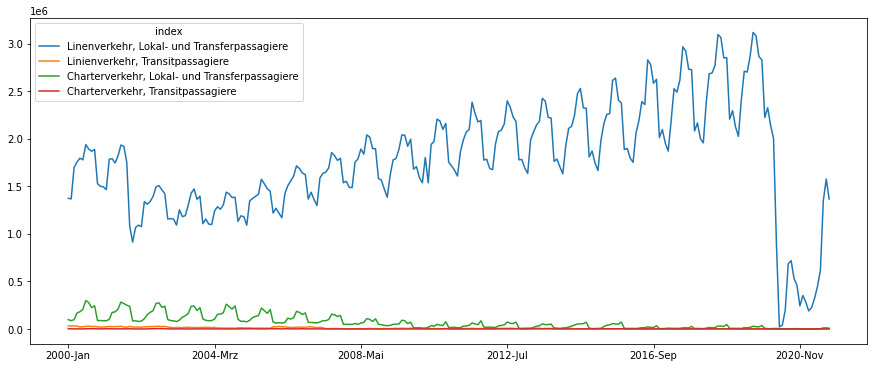

In [15]:
df.T.plot(figsize=(15,6))

<AxesSubplot:>

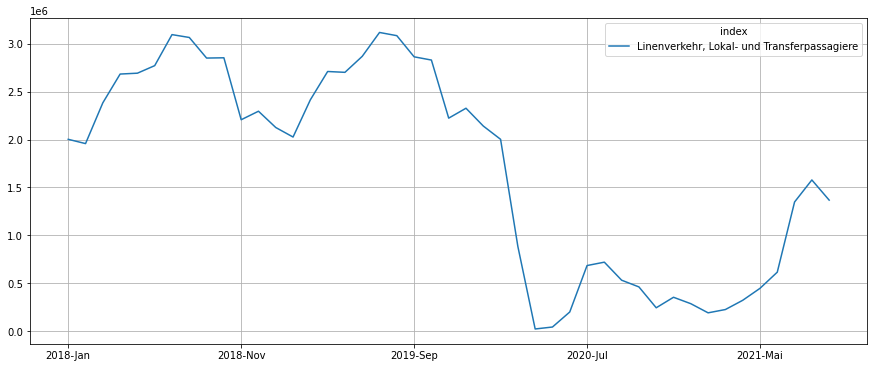

In [16]:
#Plot grösste Kategorie (Linienverkehr, Lokal- und Transitpassagiere) seit 2018
df.iloc[:1,216:264].T.plot(figsize=(15,6), grid=True)